                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                916.793
Distribution:                  Normal   AIC:                          -1827.59
Method:            Maximum Likelihood   BIC:                          -1814.71
                                        No. Observations:                  540
Date:                Wed, Jun 04 2025   Df Residuals:                      539
Time:                        19:46:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0121  1.892e-03      6.389  1.675e-10 [8.

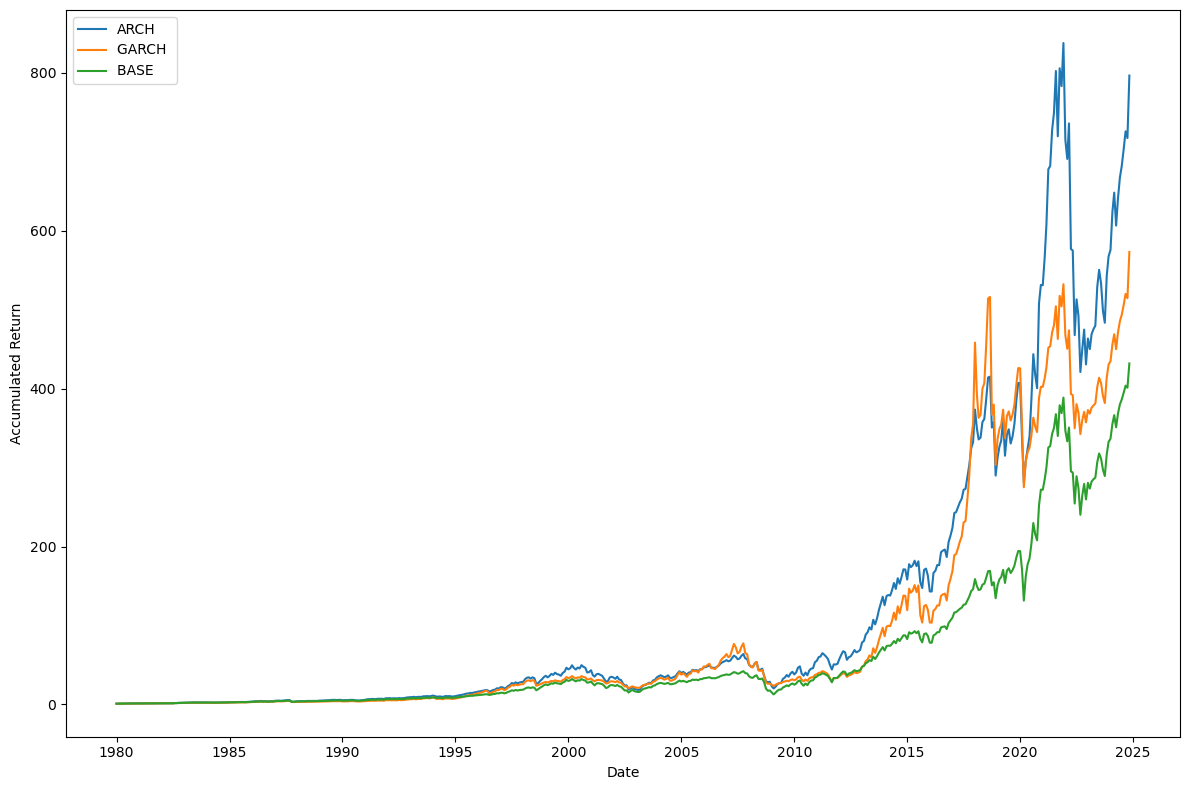

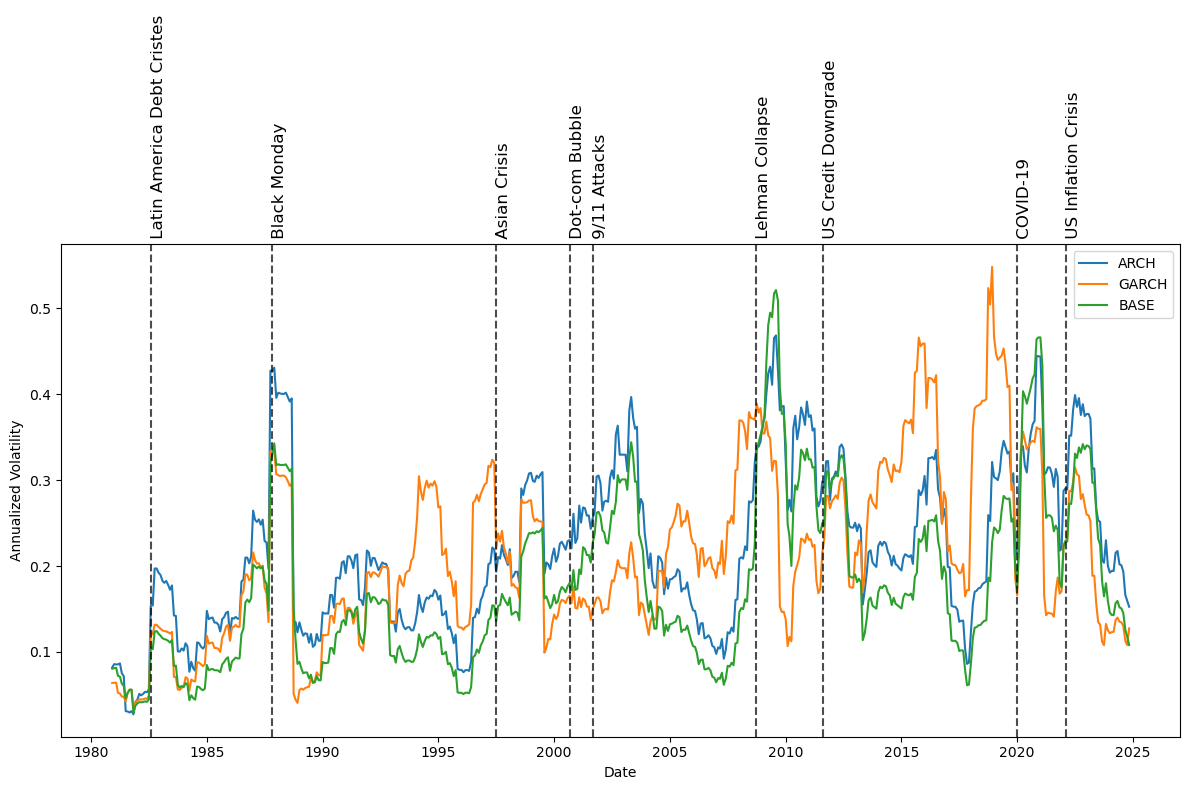

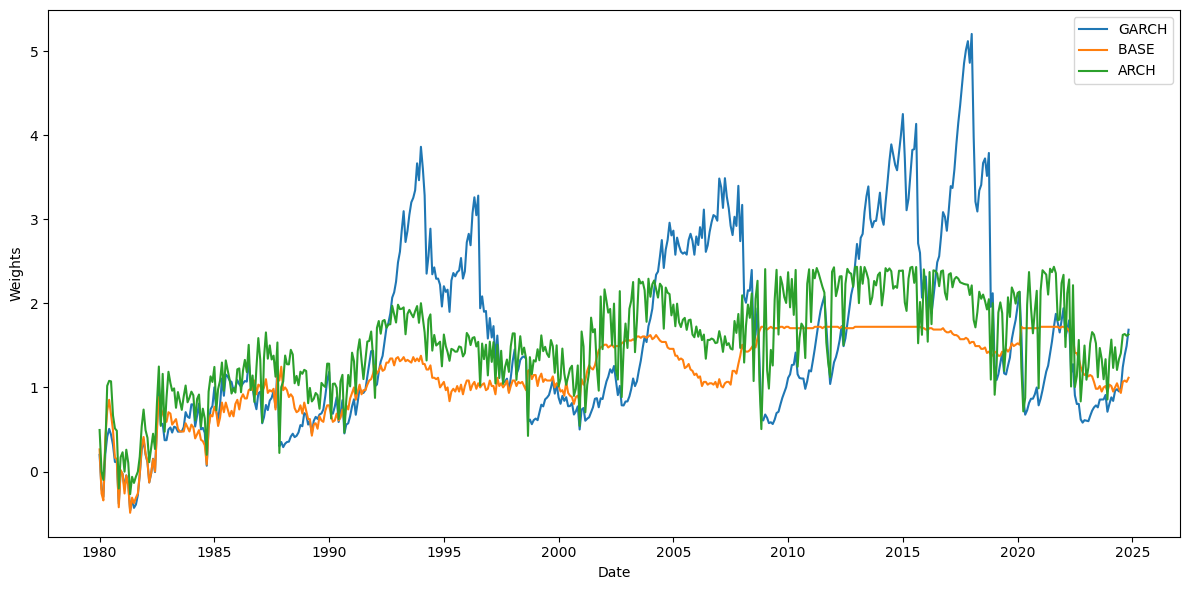

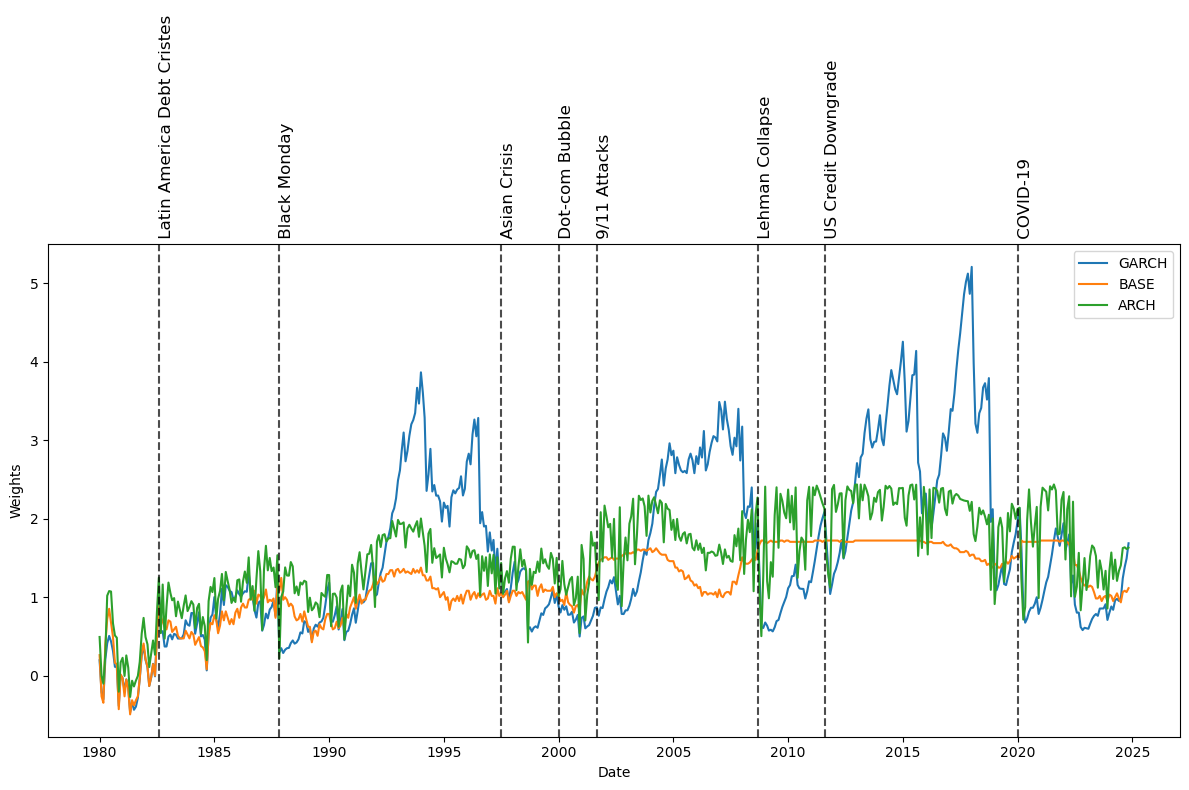

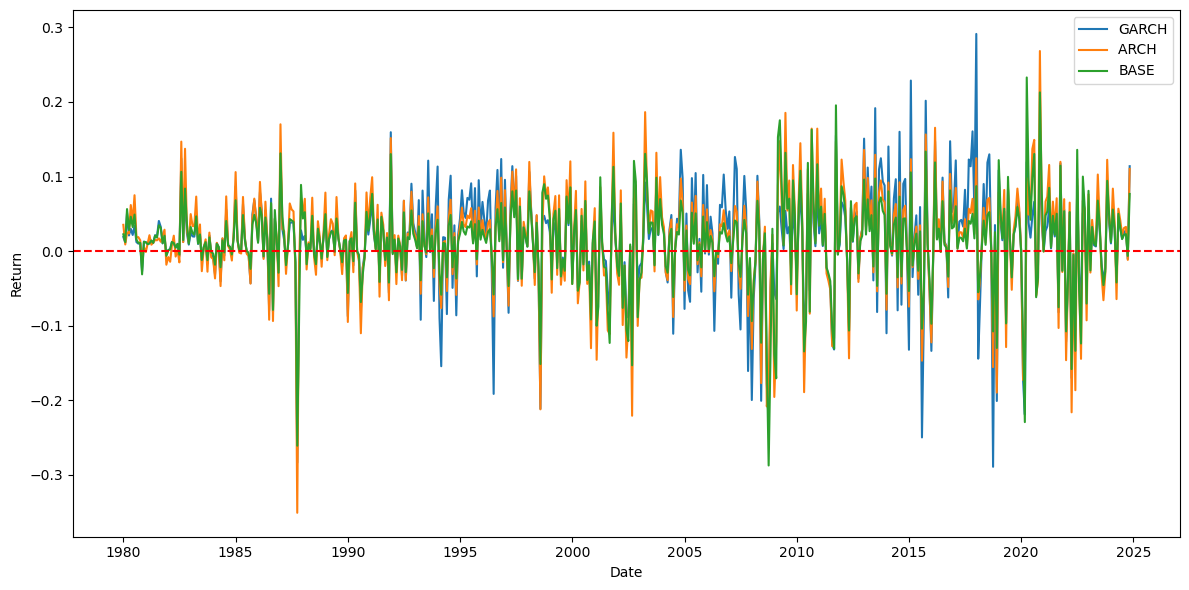

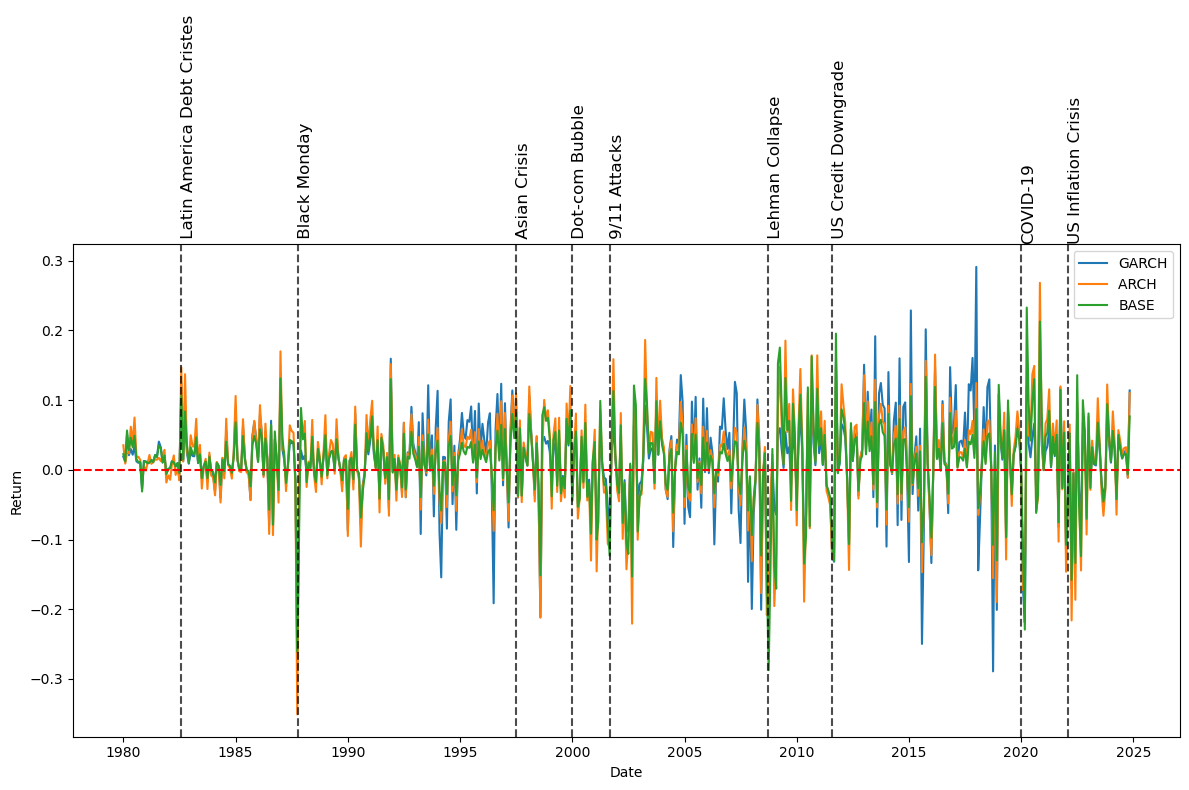

garch portfolio values: {'mean': 0.014247692672669779, 'std_dev': 0.06814116389211701, 't_stat': 4.854330865091925, 'p_value': 1.5852493764707418e-06}
arch portfolio values: {'mean': 0.014939397063664065, 'std_dev': 0.06916522431495949, 't_stat': 5.014638874020972, 'p_value': 7.22612041533597e-07}
base portfolio values: {'mean': 0.013062004140347775, 'std_dev': 0.0583210992536354, 't_stat': 5.199702527663059, 'p_value': 2.840715257941228e-07}

ARCH model:
Ljung-Box test on z_t:
     lb_stat  lb_pvalue
12  8.305166   0.760851
Ljung-Box test on z_t^2:
      lb_stat  lb_pvalue
12  11.407204   0.494381

GARCH model:
Ljung-Box test on z_t:
     lb_stat  lb_pvalue
12  7.071961   0.852822
Ljung-Box test on z_t^2:
     lb_stat  lb_pvalue
12  5.842882   0.923794


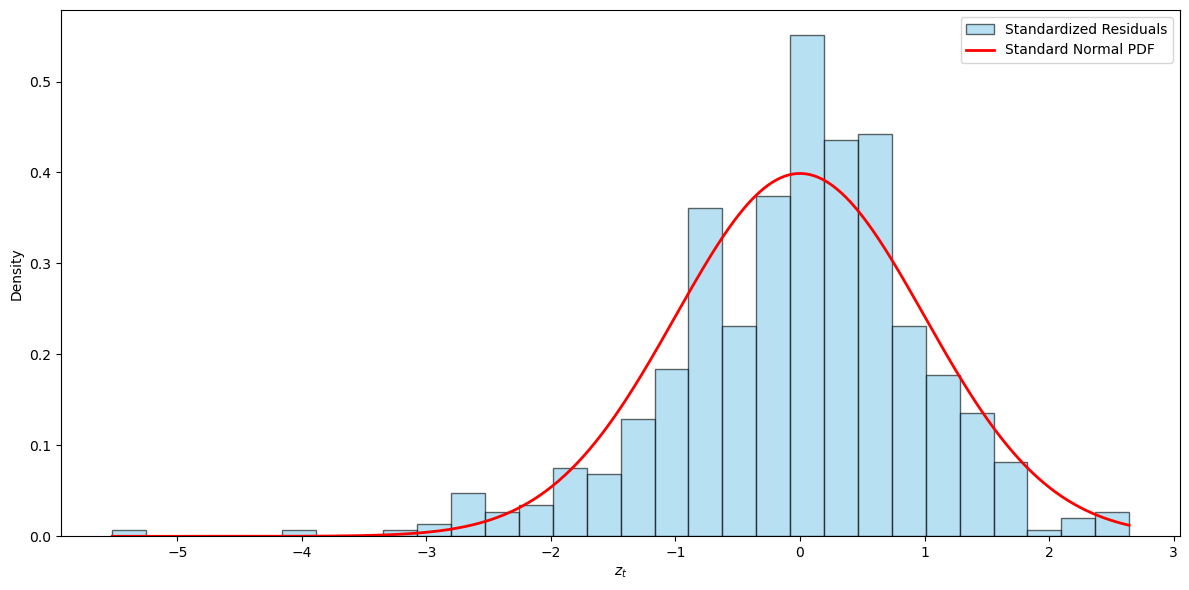

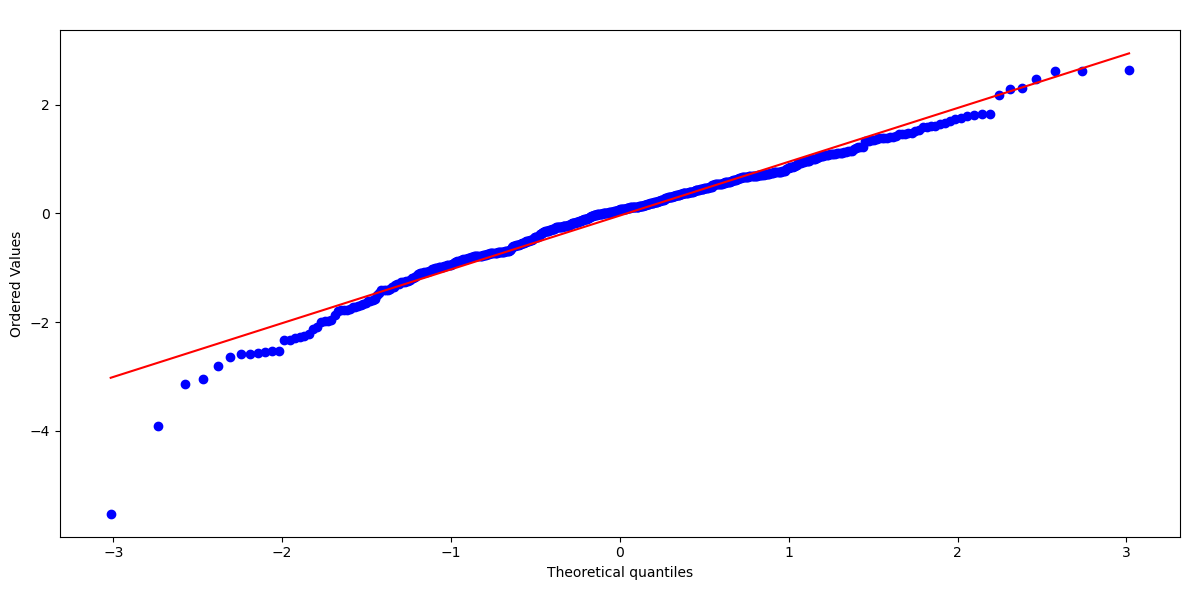

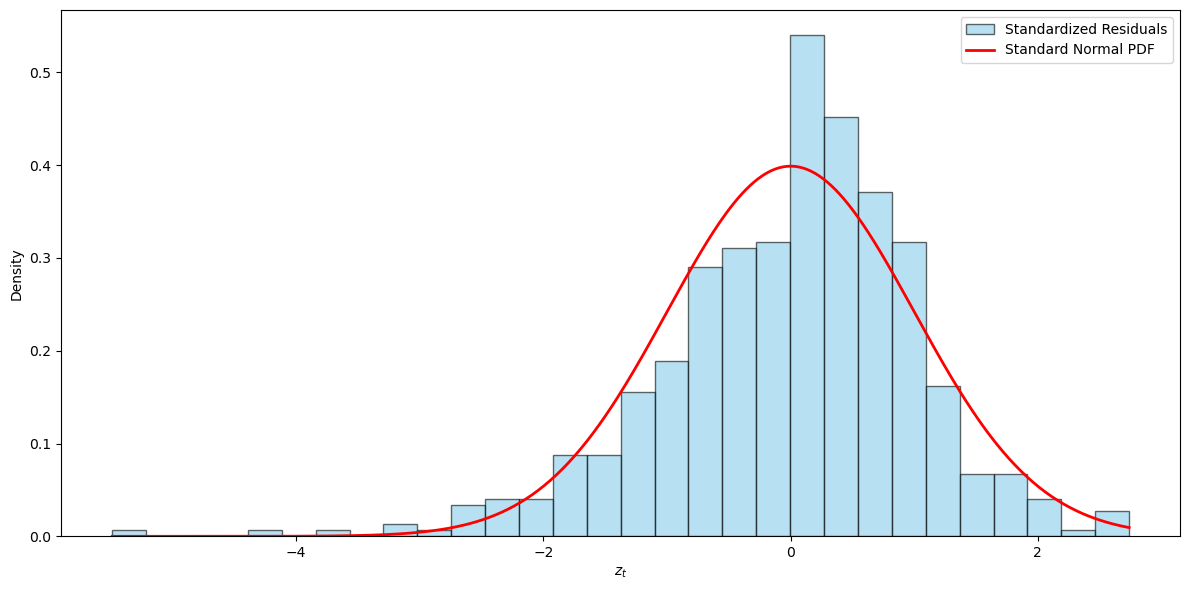

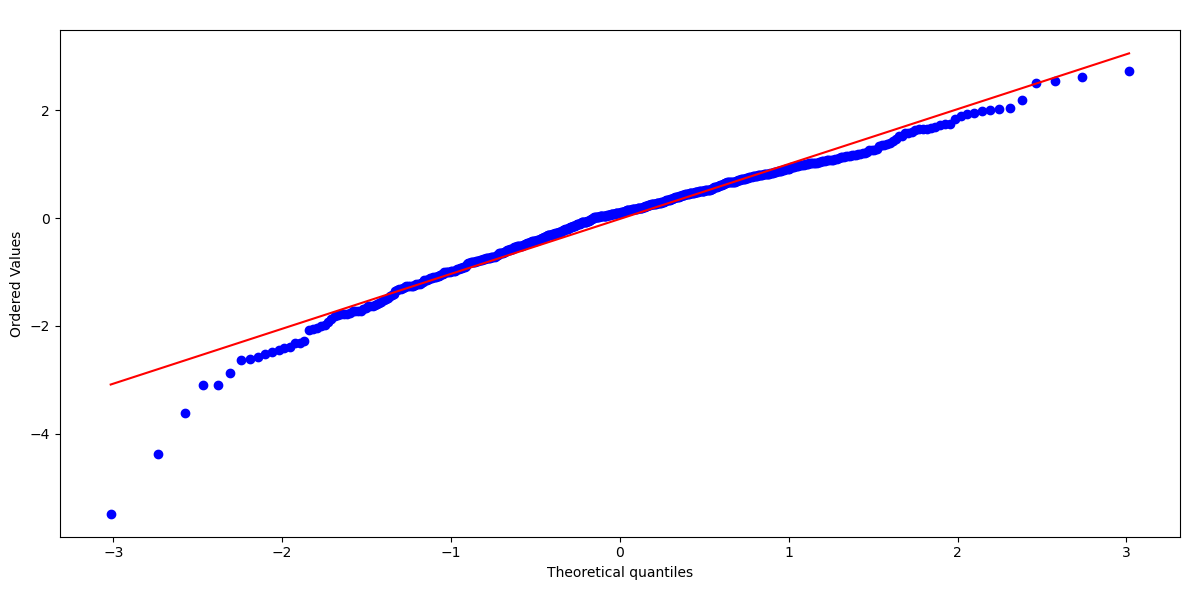

ARCH Test (LM stat, p-value): 26.69878855836496 0.008536405263807044 2.285697666016047 0.007776909604811889
GARCH Test (LM stat, p-value): 26.200666004882915 0.01005344736518093 2.240826508125988 0.0092214568922689

ADF Test:
  Test Statistic      : -22.4676
  p-value             : 0.0000
  # of Lags Used      : 0
  # of Observations   : 539
  Critical Values     :
    1% level     : -3.4425
    5% level     : -2.8669
    10% level     : -2.5696
  Best Information Criterion (AIC): -1747.6690

SR for ARCH: 0.21599578706828368
SR for GARCH: 0.20909083230845782
SR for constan variance : 0.22396704293144074
Tau 1 (arch-constant): -0.007971255863157056
Tau 2 (garch-constant): -0.014876210622982916
Tau 3 (arch-garch): 0.00690495475982586

y1_ optimal bandwidth: 1
y2_ optimal bandwidth: 1
y3_ optimal bandwidth: 1

hac variance: 2.048526649078217
Standard error: 1.4312674973876185
hac variance for tau 2: 10.25342333281598
Standard error for tau 2: 3.202096708848123
hac variance for tau 3: 1.24

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
from scipy.stats import norm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import warnings
from arch.univariate.base import DataScaleWarning

warnings.filterwarnings("ignore", category=DataScaleWarning)

#Load data
file_path = r"C:\Users\sofie\OneDrive\Documenten\BA\Python code\data til python\data.xlsx"
data = pd.read_excel(file_path)
data['Date'] = pd.to_datetime(data['Date'].astype(str), format='%Y%m')
data['Excess_Return'] = data['Mkt-RF']/100 # excess return
data['Risk_Free'] = data['RF']/100 # risk free 
returns= (data['Excess_Return'] + data['Risk_Free']).dropna()#return 

#Fit ARCH(1) model
arch = arch_model(returns, mean="constant", vol='ARCH', p=1, dist='normal').fit(disp='off')
data['Return_arch']  = arch.params["mu"]
data['Variance'] = arch.conditional_volatility**2
print(arch.summary())

#ARCH(1) portfolio weighs 
gamma=3
data['Risk_Free_back'] = data['Risk_Free'].shift(-1)
data['portfolio_weighs'] = (1 / gamma) * ((data['Return_arch'] - data['Risk_Free_back']) / data['Variance'])

#Return ARCH(1,1) portfolio
data['arch_portfolio_return']=data['portfolio_weighs']*returns+(1-data['portfolio_weighs'])*data['Risk_Free']

#Baseline model 
baseline = arch_model(returns, mean="constant", vol="Constant", dist="normal").fit(disp="off")
data['expected_baseline_return'] = baseline.forecast(start=0).mean.iloc[:, 0]
data['Baseline_variance'] = baseline.conditional_volatility**2
print(baseline.summary())

#Baseline portfolio weighs 
data['portfolio_weighs_baseline'] = (1/gamma)*((data['expected_baseline_return']-data['Risk_Free_back'])/data['Baseline_variance'])

#Return baseline portfoilo
data['base_portfolio_return']=data['portfolio_weighs_baseline']*returns+(1-data['portfolio_weighs_baseline'])*data['Risk_Free']

#Fit GARCH(1,1) model
garch = arch_model(returns, mean='constant', vol='GARCH', p=1, q=1, dist='normal').fit(disp='off')
print(garch.summary())

data['GARCH Variance'] = garch.conditional_volatility**2

#GARCH(1,1) portfolio weights 
data['GARCH_return']  = garch.params["mu"] 
data['GARCH_portfolio_weighs'] = (1 / gamma) * ((data['GARCH_return'] - data['Risk_Free_back']) / data['GARCH Variance'])

#Return GARCH portfolio
data['garch_portfolio_return']=data['GARCH_portfolio_weighs']*returns+(1-data['GARCH_portfolio_weighs'])*data['Risk_Free']

#Accumulated portfolio returns with dates 
data['arch_cumulative_return'] = (1 + data['arch_portfolio_return']).cumprod()
data['garch_cumlative_return']= (1+data['garch_portfolio_return']).cumprod()
data['base_cumlative_return']=(1+data['base_portfolio_return']).cumprod()
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['arch_cumulative_return'], label='ARCH')
plt.plot(data['Date'], data['garch_cumlative_return'], label='GARCH ')
plt.plot(data['Date'], data['base_cumlative_return'], label='BASE ')
plt.xlabel('Date')
plt.ylabel('Accumulated Return')
plt.legend()
plt.tight_layout()
plt.show()



#Annualized volatility 
data['arch_annualized_vol'] = data['arch_portfolio_return'].rolling(window=12).std() * np.sqrt(12)
data['garch_annualized_vol'] = data['garch_portfolio_return'].rolling(window=12).std() * np.sqrt(12)
data['base_annualized_vol'] = data['base_portfolio_return'].rolling(window=12).std() * np.sqrt(12)

plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['arch_annualized_vol'], label='ARCH')
plt.plot(data['Date'], data['garch_annualized_vol'], label='GARCH')
plt.plot(data['Date'], data['base_annualized_vol'], label='BASE')
crisis_dates = {
    " Latin America Debt Cristes ": "1982-08-01",
    " Black Monday ": "1987-10-19",
    " Asian Crisis ": "1997-07-02",
    " Dot-com Bubble": "2000-09-01",
    " 9/11 Attacks ": "2001-09-11",
    " Lehman Collapse": "2008-09-15",
    " US Credit Downgrade ": "2011-08-05",
    " COVID-19 ": "2020-01-01",
    " US Inflation Crisis": "2022-02-02"
}
for label, date_str in crisis_dates.items():
    crisis_date = pd.to_datetime(date_str)
    plt.axvline(crisis_date, color='black', linestyle='--', alpha=0.7)
    plt.text(crisis_date, plt.ylim()[1], label, rotation=90, va='bottom', fontsize=12, color='black')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.tight_layout()
plt.show()


#Output to excel
output_path = r"C:\Users\sofie\OneDrive\Documenten\BA\Python code\data til python\samlet_portfolio_weights_22.04.xlsx"
data[['Date', 'portfolio_weighs_baseline', 'portfolio_weighs', 'GARCH_portfolio_weighs']].to_excel(output_path, index=False)

#Comparison of the three portfolio weighs 
plt.figure(figsize=(12, 6))
plt.plot(data['Date'],data['GARCH_portfolio_weighs'], label='GARCH')
plt.plot(data['Date'],data['portfolio_weighs_baseline'], label='BASE ')
plt.plot(data['Date'],data['portfolio_weighs'], label='ARCH')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.legend()
plt.tight_layout()
plt.show()

#Portfolio weighs with crises date from 1980-2024
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['GARCH_portfolio_weighs'], label='GARCH')
plt.plot(data['Date'], data['portfolio_weighs_baseline'], label='BASE')
plt.plot(data['Date'], data['portfolio_weighs'], label='ARCH')
crisis_dates = {
    " Latin America Debt Cristes ": "1982-08-01",
    " Black Monday ": "1987-10-19",
    " Asian Crisis ": "1997-07-02",
    " Dot-com Bubble": "2000-01-01",
    " 9/11 Attacks ": "2001-09-11",
    " Lehman Collapse": "2008-09-15",
    " US Credit Downgrade ": "2011-08-05",
    " COVID-19 ": "2020-01-01"
}
for label, date_str in crisis_dates.items():
    crisis_date = pd.to_datetime(date_str)
    plt.axvline(crisis_date, color='black', linestyle='--', alpha=0.7)
    plt.text(crisis_date, plt.ylim()[1], label, rotation=90, va='bottom', fontsize=12, color='black')
plt.xlabel('Date')
plt.ylabel('Weights')
plt.legend()
plt.tight_layout()  
plt.show()

#Plot of return for the 3 strategier (comparison)
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['garch_portfolio_return'], label='GARCH')
plt.plot(data['Date'], data['arch_portfolio_return'], label='ARCH ')
plt.plot(data['Date'], data['base_portfolio_return'], label='BASE')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()
plt.show()

#Plot of return with crises
plt.figure(figsize=(12,8))
plt.plot(data['Date'], data['garch_portfolio_return'], label='GARCH')
plt.plot(data['Date'], data['arch_portfolio_return'], label='ARCH ')
plt.plot(data['Date'], data['base_portfolio_return'], label='BASE')
crisis_dates = {
    " Latin America Debt Cristes ": "1982-08-01",
    " Black Monday ": "1987-10-19",
    " Asian Crisis ": "1997-07-02",
    " Dot-com Bubble": "2000-01-01",
    " 9/11 Attacks ": "2001-09-11",
    " Lehman Collapse": "2008-09-15",
    " US Credit Downgrade ": "2011-08-05",
    "COVID-19": "2020-01-01",
    "US Inflation Crisis": "2022-02-01"
}
for label, date_str in crisis_dates.items():
    crisis_date = pd.to_datetime(date_str)
    plt.axvline(crisis_date, color='black', linestyle='--', alpha=0.7)
    plt.text(crisis_date, plt.ylim()[1], label, rotation=90, va='bottom', fontsize=12, color='black')

plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.tight_layout()
plt.show()

#Mean and std. of portfolio stragies
def mean_port(return_series, null_value=0):
    returns = return_series.dropna()
    n = len(returns)
    
    mean_return = returns.mean()
    std_dev = returns.std()
    
    # t-statistic
    t_stat = (mean_return - null_value) / (std_dev / np.sqrt(n))
    
    # two-tailed p-value
    p_value = 2 * stats.t.sf(np.abs(t_stat), df=n-1)
    
    return {
        'mean': mean_return,
        'std_dev': std_dev,
        't_stat': t_stat,
        'p_value': p_value
    }
garch_port = mean_port(data['garch_portfolio_return'])
arch_port= mean_port(data['arch_portfolio_return'])
base_port= mean_port(data['base_portfolio_return'])
print('garch portfolio values:', garch_port)
print('arch portfolio values:', arch_port)
print('base portfolio values:', base_port)

#Ljung-Box test of autocorreltion in z_t and z_t^2
residuals = {
    'ARCH': arch.std_resid,
    'GARCH': garch.std_resid
}
for name, z in residuals.items():
    print(f"\n{name} model:")
    print("Ljung-Box test on z_t:")
    print(acorr_ljungbox(z, lags=[12], return_df=True))
    print("Ljung-Box test on z_t^2:")
    print(acorr_ljungbox(z**2, lags=[12], return_df=True))


#Histogram of z_t, ARCH 
plt.figure(figsize=(12, 6))
plt.hist( arch.std_resid, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Standardized Residuals')
x = np.linspace(min( arch.std_resid), max( arch.std_resid), 500)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=1), 'r', linewidth=2, label='Standard Normal PDF')
plt.xlabel('$z_t$')
plt.ylabel('Density')
plt.tight_layout()
plt.legend()
plt.show()

# Q-Q Plot of ARCH z_t
plt.figure(figsize=(12, 6))
stats.probplot( arch.std_resid, dist="norm", plot=plt)
plt.title(' ')
plt.tight_layout()
plt.show()

#Histogram of z_t, GARCH
plt.figure(figsize=(12, 6))
plt.hist( garch.std_resid, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Standardized Residuals')
x = np.linspace(min( garch.std_resid), max( garch.std_resid), 500)
plt.plot(x, stats.norm.pdf(x, loc=0, scale=1), 'r', linewidth=2, label='Standard Normal PDF')
plt.xlabel('$z_t$')
plt.ylabel('Density')
plt.tight_layout()
plt.legend()
plt.show()


# Q-Q Plot of GARCH z_t
plt.figure(figsize=(12, 6))
stats.probplot( garch.std_resid, dist="norm", plot=plt)
plt.title(' ')
plt.tight_layout()
plt.show()




# ARCH test heteroskedasticity
arch_test_arch = het_arch(arch.resid, nlags=12)
arch_test_garch = het_arch(garch.resid, nlags=12)
print("ARCH Test (LM stat, p-value):", arch_test_arch[0], arch_test_arch[1],arch_test_arch[2], arch_test_arch[3] )
print("GARCH Test (LM stat, p-value):", arch_test_garch[0], arch_test_garch[1],arch_test_garch[2], arch_test_garch[3])
print('')


#ADF test, stationarity
adf_test = adfuller(returns, maxlag=None, autolag='AIC')
adf_stat = adf_test[0]
p_value = adf_test[1]
used_lag = adf_test[2]
n_obs = adf_test[3]
crit_vals = adf_test[4]
ic_best = adf_test[5]

print("ADF Test:")
print(f"  Test Statistic      : {adf_stat:.4f}")
print(f"  p-value             : {p_value:.4f}")
print(f"  # of Lags Used      : {used_lag}")
print(f"  # of Observations   : {n_obs}")
print("  Critical Values     :")
for key, val in crit_vals.items():
    print(f"    {key} level     : {val:.4f}")
print(f"  Best Information Criterion (AIC): {ic_best:.4f}")
print('')


#Sharpe Ratio 
mu_garch_strategi= data['garch_portfolio_return'].mean()
mu_arch_strategi= data['arch_portfolio_return'].mean()
mu_baseline_strategi= data['base_portfolio_return'].mean()

# mu/sigma
sigma_arch_strategi= data['arch_portfolio_return'].std()
sigma_base_strategi= data['base_portfolio_return'].std()
sigma_garch_strategi= data['garch_portfolio_return'].std()
Sharpe_ratio_arch = mu_arch_strategi/ sigma_arch_strategi
Sharpe_ratio_base = mu_baseline_strategi/ sigma_base_strategi
Sharpe_ratio_garch= mu_garch_strategi/sigma_garch_strategi

print("SR for ARCH:", Sharpe_ratio_arch)  
print("SR for GARCH:", Sharpe_ratio_garch)  
print("SR for constan variance :", Sharpe_ratio_base)  

#tau: SR1-SR2
tau1=Sharpe_ratio_arch-Sharpe_ratio_base
tau2=Sharpe_ratio_garch-Sharpe_ratio_base
tau3=Sharpe_ratio_arch-Sharpe_ratio_garch
print('Tau 1 (arch-constant):',tau1)
print('Tau 2 (garch-constant):',tau2)
print('Tau 3 (arch-garch):',tau3)


#HAC infercen
#Parameters
mu_base=mu_baseline_strategi
mu_arch=mu_arch_strategi
mu_garch=mu_garch_strategi
gamma_base= (data['base_portfolio_return'] ** 2).mean()
gamma_arch=(data['arch_portfolio_return']**2).mean()
gamma_garch=(data['garch_portfolio_return']**2).mean()


#Gradienter of function f (tau)
a=gamma_arch/(gamma_arch-mu_arch**2)**(3/2)
b=-gamma_base/(gamma_base-mu_base**2)**(3/3)
c=-mu_arch/(2*(gamma_arch-mu_arch**2)**(3/2))
d=mu_base/(2*(gamma_base-mu_base**2)**(3/2))
e=gamma_garch/(gamma_garch-mu_garch**2)**(3/2)
f=-mu_garch/(2*(gamma_garch-mu_garch**2)**(3/2))

gradient = np.array([a,b,c,d])
gradient2 = np.array([e,b,f,d])
gradient3 = np.array([a,e,c,f])

#Vector y with the difference in estimes from true to estimes for the 3 strategies jf. Ledoit & Wolf 2007
data['1'] = data['arch_portfolio_return'] - mu_arch
data['2'] = data['base_portfolio_return'] - mu_base
data['3'] = data['arch_portfolio_return']-gamma_arch
data['4'] = data['base_portfolio_return']-gamma_base
data['5'] = data['garch_portfolio_return'] - mu_garch
data['6'] = data['garch_portfolio_return']**2 - gamma_garch

y = data[['1', '2', '3', '4']].dropna().values
y2 = data[['5', '2', '6', '4']].dropna().values
y3 = data[['1', '5', '3', '6']].dropna().values

#Output to excel
output_path = r"C:\Users\sofie\OneDrive\Documenten\BA\Python code\data til python\y-vektorene.xlsx"#
data[['1', '2', '3', '4', '5', '6']].to_excel(output_path, index=False)


#Implement of HAC estimation propoes by Andrew and Monahun (1992)
def bartlett_kernel(j, bandwidth):
    return 1 - abs(j) / bandwidth if abs(j) <= bandwidth else 0

def compute_hac_covariance(y, bandwidth=12):
    T, k = y.shape
    hac_cov = np.zeros((k, k))
    
    for j in range(-bandwidth, bandwidth + 1):
        weight = bartlett_kernel(j, bandwidth)
        if j >= 0:
            gamma_j = (y[j:].T @ y[:T-j]) / T # ensuring the right index
        else:
            gamma_j = (y[-j+1:].T @ y[:T+j-1]) / T 
        hac_cov +=weight * gamma_j
    hac_cov*=T/(T-4)
    
    return hac_cov

#Optimal bandwith as propoes by Andrews (1991)
def andrews_bandwidth(y):
    T = y.shape[0]
    rhos = []
    for col in range(y.shape[1]):
        series = y[:, col]
        series = series - np.mean(series)
        autocov = np.corrcoef(series[1:], series[:-1])[0, 1]
        rhos.append(autocov)
    rho_hat = np.mean(rhos)
    rho_hat = np.clip(rho_hat, -0.99, 0.99)

    # Andrews (1991) bandwidth to the bartlett-kernel estimatoren
    bandwidth = 1.1447 * ((rho_hat ** 2) / (1 - rho_hat ** 2)) ** (1 / 5) * T ** (1 / 5)

    return int(np.round(bandwidth))

y_bandwitdh=andrews_bandwidth(y)
y2_bandwitdh=andrews_bandwidth(y2)
y3_bandwitdh=andrews_bandwidth(y3)
print('')
print('y1_ optimal bandwidth:',y_bandwitdh)
print('y2_ optimal bandwidth:',y2_bandwitdh)
print('y3_ optimal bandwidth:',y3_bandwitdh)
print('')

#Constrution the HAC covariance matrix 
psi_hat = compute_hac_covariance(y, bandwidth=12)
psi_hat2=compute_hac_covariance(y2,bandwidth=12)
psi_hat3=compute_hac_covariance(y3,bandwidth=12)


#Delta metode for tau 1 (ARCH-Baseline)
hac_variance  = gradient.T @ psi_hat @ gradient
std_error = np.sqrt(hac_variance)

#Delta metode for tau 2 (GARCH-Baseline)
hac_variance2  = gradient2.T @ psi_hat2 @ gradient2
std_error2 = np.sqrt(hac_variance2)

#Delta metode for tau 3 (ARCH-GARCH)
hac_variance3  = gradient3.T @ psi_hat3 @ gradient3
std_error3 = np.sqrt(hac_variance3)

print("hac variance:", hac_variance)
print("Standard error:", std_error)
print("hac variance for tau 2:", hac_variance2)
print("Standard error for tau 2:", std_error2)
print("hac variance for tau 3:", hac_variance3)
print("Standard error for tau 3:", std_error3)

#Confidens interval 95 % for tau 
z_score=1.96
lower_tau1=tau1-z_score*std_error
upper_tau1=tau1+z_score*std_error
lower_tau2=tau2-z_score*std_error2
upper_tau2=tau2+z_score*std_error2
lower_tau3=tau3-z_score*std_error3  
upper_tau3=tau3+z_score*std_error3 
print('condicens interval tau 1(arch-constant):',lower_tau1, upper_tau1)
print('condicens interval tau 2(garch-constant):',lower_tau2, upper_tau2)
print('condicens interval tau 3(arch -garch):',lower_tau3, upper_tau3)

#Test statestik
test_statistic1=tau1/std_error
test_statistic2=tau2/std_error2
test_statistic3=tau3/std_error3
#P-values 
p1_value=2*norm.cdf(-(np.abs(tau1)/std_error)) 
p2_value=2*norm.cdf(-(np.abs(tau2)/std_error2))
p3_value=2*norm.cdf(-(np.abs(tau3)/std_error3))
print('')
print('test statisitc 1', test_statistic1)
print('test statisitc 2:', test_statistic2)
print('test statisitc 3:', test_statistic3)
print('')
print('p-værdi for tau 1:', p1_value)
print('p-værdi for tau 2:', p2_value)
print('p-værdi for tau 3:', p3_value)


